### Modelo Preditivo do preço médio de Imóveis 

In [1]:
import tarfile 
import os
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from IPython.display import display

#### Carregando os dados

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()


def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)


fetch_housing_data()

housing = load_housing_data()

C:\Users\igor.bione\AppData\Local\Temp\ipykernel_21960\2519355809.py:10: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


### Análisando genericamente nosso conjunto de dados

In [ ]:
# A primeira parte de uma EDA é explorar a estrutura dos seus dados. Para isso utilizamos uma série de métodos do pandas (info, describe, head, value_counts)

housing.info() # Informações gerais dos tipos da coluna
display(housing.describe()) # Descrição geral das colunas numéricas
display(housing['ocean_proximity'].value_counts()) # Contagem das categorias da variável categórica

In [ ]:

# Outra parte importante na modelagem do problema é entender ocmo nossos dados estão distribuidos. Para isso utilizamos visualizações (como por exemplo o histograma)

housing.hist(bins=50, figsize=(20,15))
plt.show()

### Removendo os dados de teste do nosso modelo de machine learning

Agora que já observamos de forma geral como é a estrutura geral dos nossos dados podemos seguir para uma análise exploratória mais criteriosa, o entanto
antes de prosseguirmos é imprenscindivel selecionar quais dados serão usados para testaro  modelo. Fazemos isso agora para evitar que o processo de análise exploratória
acabe influenciando no teste (data spoofing) ou que aja vazamento de dados do teste para o treino (data leakage).

Existem diversas metodologias para fazer essa divisão, como por exemplo a divisão aleatória, utilizando hash ou uma divisão estratitifcado para garantir o balancemaneto das classes.



In [ ]:
# Divisão aleatória

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2) # 80% dos dados vão ser usados para treino e 20% para teste


print("Conjunto de treino:", len(train_set))
print("Conjunto de teste:", len(test_set))

In [ ]:
# Divisão aleatória com hash

###############################################################################################################################################
# Vamos supor que novos dados sejam adicionados no modelo, como garantir a consistencia? Nesse caso podemos utilizar um ID caso existas       #
# ou podemos criar um hash que vai servir como identificador daquela linha, logo, não corremos risco de vazamento de dados e garantimos que   #
# o processo de adição de novos dados seja mais eficiente.                                                                                    #
###############################################################################################################################################


from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]    

housing_with_id = housing.reset_index()   # Usando o índice como ID
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index") # Usando o índice como ID

print("Conjunto de treino:", len(train_set))
print("Conjunto de teste:", len(test_set))

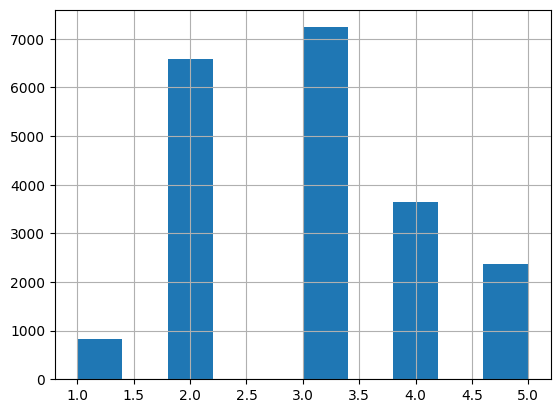

In [3]:
# Divisão estratificada

##################################################################################
# Essa divisão é importante para garantir que nosso teste seja balanceado       #
##################################################################################




housing['Faixa_de_Renda'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5]) # Criamos a categoriade renda
housing['Faixa_de_Renda'].hist() # Visualização 


split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) # Aqui criamos um objeto transformador que vai executar a divisão




In [4]:
for train_index, test_index in split.split(housing, housing['Faixa_de_Renda']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]


print("\n=== CONJUNTO DE TREINO ===")
print(strat_train_set)
print("Distribuição no treino:")
print(strat_train_set['Faixa_de_Renda'].value_counts(normalize=True))

print("\n=== CONJUNTO DE TESTE ===")
print(strat_test_set)
print("Distribuição no teste:")
print(strat_test_set['Faixa_de_Renda'].value_counts(normalize=True))




=== CONJUNTO DE TREINO ===
       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
12655    -121.46     38.52                29.0       3873.0           797.0   
15502    -117.23     33.09                 7.0       5320.0           855.0   
2908     -119.04     35.37                44.0       1618.0           310.0   
14053    -117.13     32.75                24.0       1877.0           519.0   
20496    -118.70     34.28                27.0       3536.0           646.0   
...          ...       ...                 ...          ...             ...   
15174    -117.07     33.03                14.0       6665.0          1231.0   
12661    -121.42     38.51                15.0       7901.0          1422.0   
19263    -122.72     38.44                48.0        707.0           166.0   
19140    -122.70     38.31                14.0       3155.0           580.0   
19773    -122.14     39.97                27.0       1079.0           222.0   

       population  hous

In [5]:
# Agora removemos a coluna  de Faixa de renda e seguimos para EDA no conjunto de teste

strat_train_set.drop("Faixa_de_Renda", axis=1, inplace=True)
strat_test_set.drop("Faixa_de_Renda", axis=1, inplace=True)

### Análise exploratória dos dados (No conjunto de teste)

In [15]:
housing = strat_train_set.copy() # Definimos uma cópia para trabalharmos

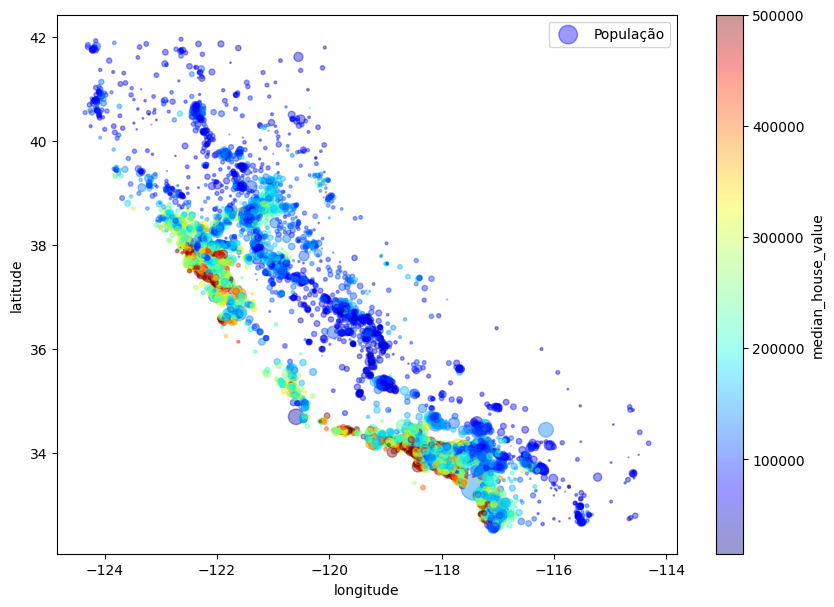

In [9]:
# Já que temos informação geográfica, que tal plotar a estrutura espacial da nossa variável resposta?

housing.plot(kind="scatter",
            x="longitude",
            y="latitude",
            alpha=0.4,
            s=housing['population']/100,
            label="População",
            figsize=(10,7),
            c="median_house_value",
            cmap=plt.get_cmap("jet"), 
            colorbar=True,)
plt.legend()
plt.show()

In [10]:
# Observar a correlação entre nossa variável resposta e as variáveis preditoras é muito importante

housing_coor = housing.iloc[:, :-1].copy()
coor_matrix = housing_coor.corr()
coor_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

In [ ]:
# Essa visualização do pandas é muito interessante 

from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

### Engenharia de atributos

Agora que já exploramos nosso conjunto de teste, descobrimos possíveis relações e entendemos a estrutura dos dados podemos prosseguir para parte de
engenharia de atributos. Aqui vamos aplicar transformadores para tratar as variáveis, seja excluindo dados ausentes seja criando novas variáveis. 

Após definir as modificações criaremos um pipeline que encapsula todas essas etapas.

In [ ]:
# Primeiro baseado no nosso problema de negócio vamos criar mais variáveis. Essa etapa depende fundamentalmente do


housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [ ]:
# Agora vamos tratar os valores ausentes, implementando uma função própria do scikit

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median") # Criando o objeto imputer que vai substituir os valores ausentes pela mediana da coluna
housing_num = housing.drop("ocean_proximity", axis=1) # Como a variável categórica "ocean_proximity" não é numérica devemos removê-la
imputer.fit(housing_num) # Calculando a mediana de cada coluna
X = imputer.transform(housing_num) # Aplicando o cálculo da mediana para substituir os valores ausentes
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index) # transformamos a mtriz novamente em dataframe

In [ ]:
housing_tr.info()

In [ ]:
# Preenchemos os valores ausentes com a mediana no caso das variáveis numéricas, agora vamos tratar as variáveis categoricas

housing_cat = housing[["ocean_proximity"]] 

# Para tratar as variáveis categóricas temo duas técnicas principais a primeira é a OrdinalEncoder, que transforma cada valor em um fator ordinal. No entanto
# esse método tem um problema que é a forma com o algorimto treina o modelo pode vir a ser influenciado por esse valor

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
ordinal_encoder = OrdinalEncoder() # Cria o objeto com a classe
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat) # Aplica

# O segundo método, e mais recomendado, é o OnehotEncoder. Nele nós criamos várias colunas definindo 0 ou 1 para cada vez que a classe corresponder áquela categoria
# isso facilita a análise mas pode ser uma limitação quando falamos de muitas variáveis, uma vez que aumenta muito o número de colunas. Para lidar com essa limitação podemos
# ou criar uma matriz esparça scipyque ocupa menos espaço ou fazer uma seleção de atributos usando PCA ou RF para pegar apenas as categorias mais importantes.

cat_enconder = OneHotEncoder()
housing_cat_1hot = cat_enconder.fit_transform(housing_cat)

Recaptiulando: Nós criamos novas variáveis que podem ser úteis para o problema, tratamos os valores nulo e codificamos nossa variável categorica
utilizando o onehotencoder. 

Agora é essencial encapsular essas etapas em um pipeline, o que vai facilitar quando o modelo entrar em produção.

### Criando Pipelines

In [7]:
##########################################################
# Vamos incorporar primeiro o cálculo da novas variáveis #
##########################################################


from sklearn.base import BaseEstimator, TransformerMixin # Importanto 

### Customize os transformadores

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6 # indices das colunas que vamos usar

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # Nenhum outro argumento além de self deve ser passado para o init
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # Nada para fazer
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

In [12]:
##############################################################################################
# Vamos incorporar agora a remoção de valores nulos e a padronização das variáveis numéricas #
##############################################################################################


# Agora já vamos adicionar direto na classe Pipeline do scikitlearn 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


housing_num = housing.iloc[:, :-1].copy()

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")), 
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler())
        ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr



array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]], shape=(16512, 12))

In [14]:
#############################################
# Vamos incorporar agora o onehotenconder  #
#############################################

# Aqui nós usamos a classe ColumnTransformer pois nosso pipeline tem tratamento de dados numericos e categoricos
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder 

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        ])


In [18]:
# Utilizando o nosso pipeline

housing_prepared = full_pipeline.fit_transform(housing)



In [ ]:
housing_prepared #Se quiser olhar as colunas é só adicionar no pipeline.

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]], shape=(16512, 17))

Agora que o pipeline tá pronto podemos começar a rodar os modelos

### Rodando os modelos de ML

In [ ]:
housing_labels = housing["median_house_value"].copy()